The code is written by Emil Vardar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all the necessary packages

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.optimizers import Adam, SGD 

In [3]:
import json
import numpy as np
import argparse
import os 
from os.path import isfile, join
import h5py
import random
import pickle
!pip3 install pickle5
import pickle5 as p
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 34.3 MB/s 


Redefine the German dataset model so that we can load its weight properly

In [4]:
initializer = tf.keras.initializers.GlorotNormal() # Xavier initialization

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), name = 'conv_1', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same', name = 'conv_2', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same', name= 'conv_3', kernel_initializer=initializer))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same', name= 'conv_4'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='elu', name='Dense_layer'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model.load_weights('/content/drive/MyDrive/CS230_Code_Data/Dataset/german_model.h5')

To do the transfer learning extract only the first layers of the pre-train model. More specifically take the first layers up until (and included) the 4th convolutional layer.

In [6]:
base_model = model
prefinal_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv_4').output, name = 'prefinal_model')
prefinal_model.summary()

Model: "prefinal_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)    

Then add new layers on top of the one given above

In [7]:
X = prefinal_model.output    # x is the output of the last layer of cutted_layer (x=features on layer block4_conv3)

X = Dropout(0.3)(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2,2))(X)
X = Flatten()(X)
X = Dropout(0.3)(X)
X = Dense(16, activation='elu')(X) 
#X = Dense(4, activation='elu')(X) 
prediction = Dense(1, activation='sigmoid')(X) 


In [8]:
final_model = Model(inputs=base_model.input, outputs=prediction, name = 'final_model')
final_model.summary()

Model: "final_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)       

Don't freeze any of the layers

In [9]:
for layer in prefinal_model.layers:
    layer.trainable = True

Import the datasets that has been preprocessed. The imports are dictionaries of type:
train_data_dict = {'spectogram:' np.array of shape (224, 224, 3), 'patient:' the id of the patient so that they are not lost, 'status:' 0(healthy) or 1(pathological)}

In [10]:
with open('/content/drive/MyDrive/CS230_Code_Data/train_data', 'rb') as su:
    train_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/test_data', 'rb') as su:
    test_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/val_data', 'rb') as su:
    val_data_dict = pickle.load(su)


In [11]:
print(len(train_data_dict))
print(len(test_data_dict))
print(len(val_data_dict))

3039
536
566


In [12]:
print('The ratio of the train dataset is:', len(train_data_dict)/(len(train_data_dict) + len(test_data_dict) + len(val_data_dict)))

The ratio of the train dataset is: 0.7338807051436851


Transfor the spectograms and the status to a keras interpretable form

In [13]:
def matrix_creator(dataset, augment = False):
    X = []
    y = []
    for person in dataset:
        spectogram = person['spectogram'] 
        status = int(person['status'])       
        X.append(spectogram)
        y.append(status)

    X = np.array(X)
    y = np.array(y)

    y = y.reshape((y.shape[0],1))
    return X, y

In [14]:
train_data, train_labels = matrix_creator(train_data_dict)  
test_data, test_labels = matrix_creator(test_data_dict)
val_data, val_labels = matrix_creator(val_data_dict)

In [15]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(3039, 224, 224, 3)
(536, 224, 224, 3)
(566, 224, 224, 3)


See an example spectogram

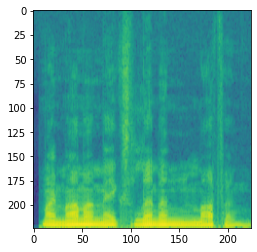

In [16]:
image = train_data[18]
plt.imshow(image)
plt.show()

Further train the base model on the stanford dataset. 
We are using Adam as optimizer with lr=5e-5. The loss function is weighted binary cross entropy. 

In [17]:
opt = Adam(learning_rate=5e-5, beta_1 = 0.9, beta_2 = 0.999)
final_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [18]:
history = final_model.fit(train_data, train_labels, epochs=40, batch_size=16, class_weight={0:5, 1:2}, validation_data=(val_data, val_labels))

Epoch 1/40
190/190 [==============================] - 19s 19ms/step - loss: 3.2182 - accuracy: 0.4403 - precision: 0.6159 - recall: 0.3345 - val_loss: 0.8476 - val_accuracy: 0.4046 - val_precision: 0.5370 - val_recall: 0.2493
Epoch 2/40
190/190 [==============================] - 3s 15ms/step - loss: 2.8578 - accuracy: 0.4567 - precision: 0.6406 - recall: 0.3453 - val_loss: 0.8429 - val_accuracy: 0.4028 - val_precision: 0.5462 - val_recall: 0.1862
Epoch 3/40
190/190 [==============================] - 3s 16ms/step - loss: 2.6220 - accuracy: 0.4682 - precision: 0.6562 - recall: 0.3561 - val_loss: 0.8375 - val_accuracy: 0.4011 - val_precision: 0.5641 - val_recall: 0.1261
Epoch 4/40
190/190 [==============================] - 3s 16ms/step - loss: 2.4762 - accuracy: 0.4715 - precision: 0.6710 - recall: 0.3428 - val_loss: 0.8310 - val_accuracy: 0.4099 - val_precision: 0.6190 - val_recall: 0.1117
Epoch 5/40
190/190 [==============================] - 3s 16ms/step - loss: 2.4778 - accuracy: 0.457

In [19]:
acc_first_train = history.history["accuracy"]
acc_first_val = history.history["val_accuracy"]

Further train the model by decreasing the learning rate to 1e-5 and decreasing the weights for the weighted binary cross entropy function

In [20]:
opt = Adam(learning_rate=1e-5, beta_1 = 0.9, beta_2 = 0.999) # decrease the learning rate and run for 20 more epochs
history = final_model.fit(train_data, train_labels, epochs=40, batch_size=16, class_weight={0:3.5, 1:2}, validation_data=(val_data, val_labels))

Epoch 1/40
190/190 [==============================] - 4s 18ms/step - loss: 1.5751 - accuracy: 0.6311 - precision: 0.8004 - recall: 0.5647 - val_loss: 0.5910 - val_accuracy: 0.6572 - val_precision: 0.7429 - val_recall: 0.6791
Epoch 2/40
190/190 [==============================] - 3s 17ms/step - loss: 1.5535 - accuracy: 0.6584 - precision: 0.7952 - recall: 0.6285 - val_loss: 0.5898 - val_accuracy: 0.6749 - val_precision: 0.7723 - val_recall: 0.6705
Epoch 3/40
190/190 [==============================] - 3s 16ms/step - loss: 1.5455 - accuracy: 0.6433 - precision: 0.7904 - recall: 0.6028 - val_loss: 0.5920 - val_accuracy: 0.6678 - val_precision: 0.7710 - val_recall: 0.6562
Epoch 4/40
190/190 [==============================] - 3s 16ms/step - loss: 1.5267 - accuracy: 0.6581 - precision: 0.7898 - recall: 0.6351 - val_loss: 0.5937 - val_accuracy: 0.6643 - val_precision: 0.7829 - val_recall: 0.6304
Epoch 5/40
190/190 [==============================] - 3s 16ms/step - loss: 1.5588 - accuracy: 0.6555

In [21]:
acc_second_train = history.history["accuracy"]
acc_second_val = history.history["val_accuracy"]

Let's look at the accuracy and F1 score for when the chunks in the test set is seen as individuals. Observe that the test set accuracy here is much lower after we have processed the chunks together to indicate whether one patient has pathological voice or not

In [22]:
test_loss, test_acc, test_prec, test_recall = final_model.evaluate(test_data, test_labels)
print('acc:', test_acc)
print('recall:', test_recall)
print('precision:', test_prec)


17/17 [==============================] - 0s 14ms/step - loss: 0.5135 - accuracy: 0.7537 - precision: 0.8295 - recall: 0.7972
acc: 0.753731369972229
recall: 0.7972221970558167
precision: 0.8294797539710999


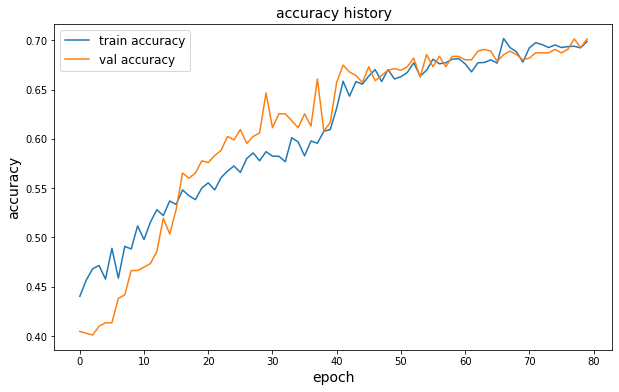

In [23]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,6))
acc_train = acc_first_train + acc_second_train
acc_val = acc_first_val + acc_second_val
plt.plot(acc_train, label="train accuracy")
plt.plot(acc_val, label="val accuracy")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('accuracy history', fontsize=14)
plt.legend(fontsize='large')

f.savefig('accuracy_history.pdf', bbox_inches='tight')

Process the chunks together so that they indicate if one person is pathological or not. Do it also for the validaiton dataset so that we have 2 differnet results. Observe that the code given below is quite bad and unnecesarily complicated. However, since we did not have enough time left on the project, we could not make it more efficient. 

In [24]:
amount = {}
prediction_dict = {}
keys = []

for test_data in test_data_dict:
    patient = test_data['patient']
    spectogram = test_data['spectogram']
    spectogram = np.expand_dims(spectogram, axis = 0)
    prediction = final_model.predict(spectogram)
    prediction = np.round(prediction[0])
    if patient not in prediction_dict:
        prediction_dict[patient] = prediction[0]
        amount[patient] = 1
        keys.append(patient)
    else:     
        prediction_dict[patient] = prediction_dict[patient] + prediction[0]
        amount[patient] = amount[patient] + 1


In [25]:
amount_val = {}
prediction_dict_val = {}
keys_val = []

for val_data in val_data_dict:
    patient = val_data['patient']
    spectogram = val_data['spectogram']
    spectogram = np.expand_dims(spectogram, axis = 0)
    prediction = final_model.predict(spectogram)
    prediction = np.round(prediction[0])
    if patient not in prediction_dict_val:
        prediction_dict_val[patient] = prediction[0]
        amount_val[patient] = 1
        keys_val.append(patient)
    else:     
        prediction_dict_val[patient] = prediction_dict_val[patient] + prediction[0]
        amount_val[patient] = amount_val[patient] + 1


In [26]:
predicted_values = {}
for patient in amount:
    mean = prediction_dict[patient]/amount[patient]
    if mean > 0.5:
        predicted_values[patient] = 1
    else: 
        predicted_values[patient] = 0

In [27]:
predicted_values_val = {}
for patient in amount_val:
    mean = prediction_dict_val[patient]/amount_val[patient]
    if mean > 0.5:
        predicted_values_val[patient] = 1
    else: 
        predicted_values_val[patient] = 0

In [28]:
print(predicted_values)
print(predicted_values_val)

{'PT033ENSS': 1, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 0, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 0, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 0, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 0, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, 'PT122_ENSS': 1, 'PT123_ENSS': 1, 'PT087_ENSS': 1, 'PT024ENSS': 0, 'NYU1018_ENSS': 1, 'BL08_ENSS': 0, 'LA7008_ENSS': 0, 'PT100_ENSS': 1, 'PT072_ENSS': 1, 'PT018ENSS': 1, 'PT046_ENSS': 1, 'Sj30003_E_NSS': 0, 'PT010ENSS': 1, 'SJ4002_eNSS': 0, 'PT080_ENSS': 0, 'NYU1020_ENSS': 1}
{'LA9012_ENSS': 0, 'PT102_ENSS': 0, 'PT098_ENSS': 1, 'PT136_ENSS': 1, 'PT093_ENSS': 1, 'PT015ENSS': 1, 'SJ7001_ENSS': 0, 'Sj4007_eNSS': 0, 'LA9002_ENSS': 1, 'SJ5006ENSS': 1, 'Sj6004_ENSS': 0, 'LA8001_ENSS': 0, 'SJ2011_ENSS': 0, 'PT067_ENSS': 0, 'SJ4001_eNSS': 0, 'LA9014_ENSS': 0, 'PT104_ENSS': 1, 'PT038_ENSS': 1, 'SJ5002ENSS': 0, 'PT012ENSS': 1, 'LA1001ENSS': 

In [29]:
path_to_protocol51 = '/content/drive/MyDrive/CS230_Code_Data/Dataset/pandas_audio_labels.pkl'

with open(path_to_protocol51, "rb") as fh:
  stanford = p.load(fh)

In [30]:
def find_status(Condition):
    """Extract the status of the patient
    0: Normal
    1: Pathological"""
    Condition = str(Condition)
    if (Condition == "Normal"):
        return 0
    else:
        return 1

In [31]:
def find_gt_labels(gt_labels, pandas_data, keys): 
    for index, rows in pandas_data.iterrows():
        if rows.File_Name in keys:
            status = find_status(rows.GRBAS_Category)
            gt_labels[rows.File_Name] = status
    return gt_labels

In [32]:
gt_labels = {}
gt_labels = find_gt_labels(gt_labels, stanford, keys)

gt_labels_val = {}
gt_labels_val = find_gt_labels(gt_labels_val, stanford, keys_val)

In [33]:
print(gt_labels)
print(predicted_values)

print(gt_labels_val)
print(predicted_values_val)

{'PT033ENSS': 0, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 0, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 1, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 0, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 0, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, 'PT122_ENSS': 1, 'PT123_ENSS': 1, 'PT087_ENSS': 1, 'PT024ENSS': 0, 'NYU1018_ENSS': 1, 'BL08_ENSS': 0, 'LA7008_ENSS': 1, 'PT100_ENSS': 1, 'PT072_ENSS': 1, 'PT018ENSS': 1, 'PT046_ENSS': 1, 'Sj30003_E_NSS': 1, 'PT010ENSS': 0, 'SJ4002_eNSS': 0, 'PT080_ENSS': 1, 'NYU1020_ENSS': 0}
{'PT033ENSS': 1, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 0, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 0, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 0, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 0, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, '

In [34]:
count = 0
tp = 0
tn = 0
fp = 0
fn = 0
for key in predicted_values:
    count += 1
    our_est = predicted_values[key]
    gt = gt_labels[key]
    if gt == 1 and gt == our_est:
        tp += 1
    elif gt == 1 and gt != our_est:
        fn += 1
    elif gt == 0 and gt == our_est:
        tn += 1
    else:
        fp += 1


acc = (tp + tn)/count
prec = tp/(tp + fp)
recall = tp/(tp + fn)
print('Accuracy for the test set is:', acc)
print('F1 score for the test set is:', (2*prec*recall)/(prec+ recall))

Accuracy for the test set is: 0.8108108108108109
F1 score for the test set is: 0.851063829787234


In [35]:
count = 0
tp = 0
tn = 0
fp = 0
fn = 0
for key in predicted_values_val:
    count += 1
    our_est = predicted_values_val[key]
    gt = gt_labels_val[key]
    if gt == 1 and gt == our_est:
        tp += 1
    elif gt == 1 and gt != our_est:
        fn += 1
    elif gt == 0 and gt == our_est:
        tn += 1
    else:
        fp += 1


acc = (tp + tn)/count
prec = tp/(tp + fp)
recall = tp/(tp + fn)
print('Accuracy for the validaiton set is:', acc)
print('F1 score for the validaiton set is:', (2*prec*recall)/(prec+ recall))

Accuracy for the validaiton set is: 0.75
F1 score for the validaiton set is: 0.7727272727272727
